In [1]:
import pandas_datareader.data as pdr
import yfinance as yf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

C:\Users\mvideo\Snapshots\envs\yfinance\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

start и end - период, на котором будет проходить обучение.
start_test и end_test - период, на котором будет проходить предсказание.
seq_len - количество предыдущих дневных цен (признаков), на основе которых делается предсказание цены дня.

In [3]:
start = "2003-01-01"
end = "2019-04-01"
#start_test = "2017-12-15"
#end_test = "2018-02-01"
start_test = "2019-03-19"
end_test = "2019-05-01"
ticker = "BMW.DE"
train_file_all = "stock_prices_all.csv"
test_file_all = "test_all.csv"
scal_file_all = "scal_all.csv"
seq_len = 10
x = []
x_all = []
x_1 = []
x_2 = []
x_3 = []
x_4 = []
x_5 = []
y = []
new_x = []
new_x_all = []
new_x_1 = []
new_x_2 = []
new_x_3 = []
new_x_4 = []
new_x_5 = []
new_y = []
scal_x = []
scal_x_all = []
scal_x_1 = []
scal_x_2 = []
scal_x_3 = []
scal_x_4 = []
scal_x_5 = []
scal_y = []

In [4]:
yf.pdr_override()


def get_stock_data_all(ticker, start_date, end_date, file):
    """
    Получает исторические данные по дневным ценам акций между датами
    :param ticker: компания или компании, чьи данные должны быть извлечены
    :type ticker: string or list of strings
    :param start_date: начальная дата получения цен на акции
    :type start_date: string of date "YYYY-mm-dd"
    :param end_date: конечная дата получения цен на акции
    :type end_date: string of date "YYYY-mm-dd"
    :param file: имя возвращаемого файла с данными
    :return: файл формата csv
    """
    i = 1
    all_data = 0
    while i > 0:
        try:
            all_data = yf.download(ticker, start_date, end_date)
            i = 0
        except ValueError:
            i += 1
            if i < 5:
                print("ValueError, trying again")
                time.sleep(10)
            else:
                print("Tried 5 times, Yahoo error. Trying after 2 minutes")
                i = 1
                time.sleep(120)
    print("download ok!")
    all_data.to_csv(file)

In [5]:
def get_X_Y_all(data, seq_len, list_x, list_x_all, list_x_1, list_x_2, list_x_3, list_x_4, list_x_5, list_y):
    """
    Преобразует данные, разбивая на признаки и ответы.
    :param data: исходный массив данных
    :param seq_len: количество признаков
    :param list_x: список, в который добавляются признаки
    :param list_y: список, в который добавляются ответы
    """
    for i in range(len(data) - seq_len):
        i1 = np.array(data.iloc[i: i + seq_len, 5])
        i2 = np.array([data.iloc[i + seq_len, 5]], np.float64)
        i3 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 4, 2, 3, 1, 6]])
        i4 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 2, 3, 1, 6]])
        i5 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 4, 3, 1, 6]])
        i6 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 4, 2, 1, 6]])
        i7 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 4, 2, 3, 6]])
        i8 = np.array(data.iloc[i: i + seq_len, lambda df: [5, 4, 2, 3, 1]])
        list_x.append(i1)
        list_x_all.append(i3)
        list_x_1.append(i4)
        list_x_2.append(i5)
        list_x_3.append(i6)
        list_x_4.append(i7)
        list_x_5.append(i8)
        list_y.append(i2)

Получим три массива данных - тренировочный, для предсказания и для настройки скалера.

In [6]:
get_stock_data_all(ticker, start, end, train_file_all)
get_stock_data_all(ticker, start_test, end_test, test_file_all)
get_stock_data_all(ticker, start, end_test, scal_file_all)

[*********************100%***********************]  1 of 1 completed
download ok!
[*********************100%***********************]  1 of 1 completed
download ok!
[*********************100%***********************]  1 of 1 completed
download ok!


Разобьем полученные данные на признаки и ответы.

In [7]:
data = pd.read_csv(train_file_all, encoding='utf-8')
get_X_Y_all(data, seq_len, x, x_all, x_1, x_2, x_3, x_4, x_5, y)

In [8]:
new_data = pd.read_csv(test_file_all, encoding='utf-8')
get_X_Y_all(new_data, seq_len, new_x, new_x_all, new_x_1, new_x_2, new_x_3, new_x_4, new_x_5, new_y)

In [9]:
scal_data = pd.read_csv(scal_file_all, encoding='utf-8')
get_X_Y_all(scal_data, seq_len, scal_x, scal_x_all, scal_x_1, scal_x_2, scal_x_3, scal_x_4, scal_x_5, scal_y)

Преобразуем данные в формат, используемый в моделях машинного обучения.

In [10]:
x = np.array(x)
x_all = np.array(x_all)
x_1 = np.array(x_1)
x_2 = np.array(x_2)
x_3 = np.array(x_3)
x_4 = np.array(x_4)
x_5 = np.array(x_5)
y = np.array(y)
new_x = np.array(new_x)
new_x_all = np.array(new_x_all)
new_x_1 = np.array(new_x_1)
new_x_2 = np.array(new_x_2)
new_x_3 = np.array(new_x_3)
new_x_4 = np.array(new_x_4)
new_x_5 = np.array(new_x_5)
new_y = np.array(new_y)
scal_x = np.array(scal_x)
scal_x_all = np.array(scal_x_all)
scal_x_1 = np.array(scal_x_1)
scal_x_2 = np.array(scal_x_2)
scal_x_3 = np.array(scal_x_3)
scal_x_4 = np.array(scal_x_4)
scal_x_5 = np.array(scal_x_5)
scal_y = np.array(scal_y)

Произведем скалинг данных

In [11]:
X = [x_all, x_1, x_2, x_3, x_4, x_5]
NEW_X = [new_x_all, new_x_1, new_x_2, new_x_3, new_x_4, new_x_5]

scalers = {}
for i in range(scal_x_all.shape[2]):
    scalers[i] = StandardScaler()
    scalers[i].fit_transform(scal_x_all[:, :, i])
    scal_x_all[:, :, i] = scalers[i].transform(scal_x_all[:, :, i])
    if i == 0:
        x = scalers[i].transform(x)
        new_x = scalers[i].transform(new_x)
        for t in range(6):
            X[t][:, :, i] = scalers[i].transform(X[t][:, :, i])
            NEW_X[t][:, :, i] = scalers[i].transform(NEW_X[t][:, :, i])
    else:
        for t in range(6):
            if t == 0:
                X[t][:, :, i] = scalers[i].transform(X[t][:, :, i])
                NEW_X[t][:, :, i] = scalers[i].transform(NEW_X[t][:, :, i])
            else:
                if t < i:
                    X[t][:, :, i - 1] = scalers[i].transform(X[t][:, :, i - 1])
                    NEW_X[t][:, :, i - 1] = scalers[i].transform(NEW_X[t][:, :, i - 1])
                if t > i:
                    X[t][:, :, i] = scalers[i].transform(X[t][:, :, i])
                    NEW_X[t][:, :, i] = scalers[i].transform(NEW_X[t][:, :, i])
                    
scaler_y = StandardScaler()
scaler_y.fit_transform(scal_y)
y = scaler_y.transform(y)

Применим PCA.

In [12]:
scal_x_all_pca = scal_x_all[:, :, 1:5]
scal_x_all_pca.shape = (scal_x_all_pca.shape[0] * scal_x_all_pca.shape[1], 4)
pca = PCA(n_components = 1)
scal_XPCAreduced = pca.fit_transform(scal_x_all_pca)

x_all_pca = np.zeros((len(x_all),10,3))
for i in range(len(x_all)):
    z = np.zeros((10,3))
    for j in range(len(z)):
        z[j][0] = x_all[i, j, 0]
        z[j][1] = pca.transform(x_all[i, j, 1:5].reshape(1, -1))
        z[j][2] = x_all[i, j, 5]
    x_all_pca[i] = z

x_6 = np.zeros((len(x_all_pca),10,2))
for i in range(len(x_all_pca)):
    for j in range(10):
        x_6[i][j][0] = x_all_pca[i, j, 0]
        x_6[i][j][1] = x_all_pca[i, j, 2]

x_pca = x_all_pca[:, :, :2]

new_x_all_pca = np.zeros((len(new_x_all),10,3))
for i in range(len(new_x_all)):
    z = np.zeros((10,3))
    for j in range(len(z)):
        z[j][0] = new_x_all[i, j, 0]
        z[j][1] = pca.transform(new_x_all[i, j, 1:5].reshape(1, -1))
        z[j][2] = new_x_all[i, j, 5]
    new_x_all_pca[i] = z

new_x_6 = np.zeros((len(new_x_all_pca),10,2))
for i in range(len(new_x_all_pca)):
    for j in range(10):
        new_x_6[i][j][0] = new_x_all_pca[i, j, 0]
        new_x_6[i][j][1] = new_x_all_pca[i, j, 2]

new_x_pca = new_x_all_pca[:, :, :2]

Разобьем тренировочные данные на обучение и проверку в соотношении 9 к 1 и перемешаем их.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
X_train_all, X_valid_all, y_train_all, y_valid_all = train_test_split(x_all, y, test_size=0.1, random_state=42, shuffle=True)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(x_1, y, test_size=0.1, random_state=42, shuffle=True)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(x_2, y, test_size=0.1, random_state=42, shuffle=True)
X_train_3, X_valid_3, y_train_3, y_valid_3 = train_test_split(x_3, y, test_size=0.1, random_state=42, shuffle=True)
X_train_4, X_valid_4, y_train_4, y_valid_4 = train_test_split(x_4, y, test_size=0.1, random_state=42, shuffle=True)
X_train_5, X_valid_5, y_train_5, y_valid_5 = train_test_split(x_5, y, test_size=0.1, random_state=42, shuffle=True)
X_train_6, X_valid_6, y_train_6, y_valid_6 = train_test_split(x_6, y, test_size=0.1, random_state=42, shuffle=True)
X_train_pca, X_valid_pca, y_train_pca, y_valid_pca = train_test_split(x_pca, y, test_size=0.1, random_state=42, shuffle=True)
X_train_all_pca, X_valid_all_pca, y_train_all_pca, y_valid_all_pca = train_test_split(x_all_pca, y, test_size=0.1, random_state=42, shuffle=True)

Обучим 7 различных моделей и оценим точность для каждой модели по среднеквадратической ошибке
(mean squared error, MSE) и R2 — коэффициенту детерминации.

In [14]:
model_list = [
   ('lr', LinearRegression()),
   ('lasso', Lasso(random_state=42)),
   ('ridge', Ridge(random_state=42)),
   ('enet', ElasticNet(random_state=42)),
   ('knn', KNeighborsRegressor()),
   ('dt', DecisionTreeRegressor(random_state=42)),
   ('rf', RandomForestRegressor(random_state=42))
]

score_list = []

for name, model in model_list:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    r2_score_train = r2_score(y_train, y_pred_train)
    r2_score_valid = r2_score(y_valid, y_pred_valid)
    mse_score_train = mean_squared_error(y_train, y_pred_train)
    mse_score_valid = mean_squared_error(y_valid, y_pred_valid)
    score_list.append((name, r2_score_train, r2_score_valid, mse_score_train, mse_score_valid))

for model, score1, score2, score3, score4 in score_list:
    print('{a}: \n\tr2 train: {b} \n\tr2 valid: {c}'.format(a=model, b=np.round(score1, 4), c=np.round(score2, 4)))
    print('\tmse train: {d} \n\tmse valid: {e}'.format(d=np.round(score3, 4), e=np.round(score4, 4)))

lr: 
	r2 train: 0.9988 
	r2 valid: 0.999
	mse train: 0.0012 
	mse valid: 0.001
lasso: 
	r2 train: 0.0052 
	r2 valid: -0.0289
	mse train: 0.9981 
	mse valid: 0.9552
ridge: 
	r2 train: 0.9988 
	r2 valid: 0.9989
	mse train: 0.0012 
	mse valid: 0.001
enet: 
	r2 train: 0.7224 
	r2 valid: 0.7158
	mse train: 0.2785 
	mse valid: 0.2639
knn: 
	r2 train: 0.9988 
	r2 valid: 0.9984
	mse train: 0.0012 
	mse valid: 0.0015
dt: 
	r2 train: 1.0 
	r2 valid: 0.998
	mse train: 0.0 
	mse valid: 0.0019
rf: 
	r2 train: 0.9998 
	r2 valid: 0.9987
	mse train: 0.0002 
	mse valid: 0.0012


Для каждой обученной модели вычислим предсказания на контрольный период и построим график.

In [15]:
new_date = []
for i in range(len(new_data) - seq_len):
    new_date.append(new_data.iloc[i + seq_len, 0])

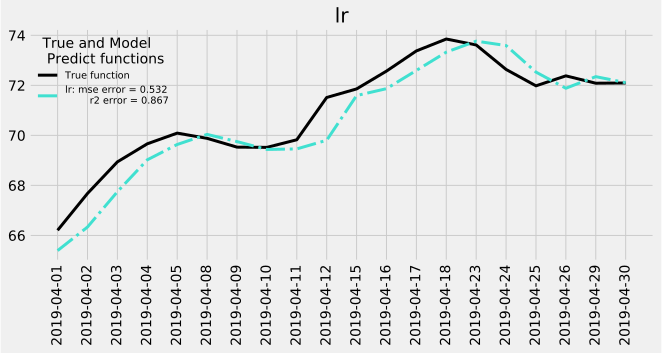

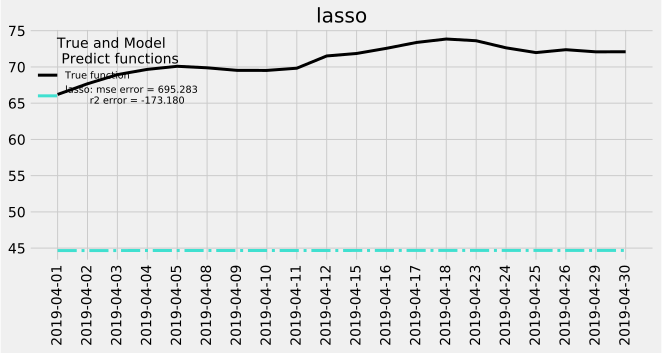

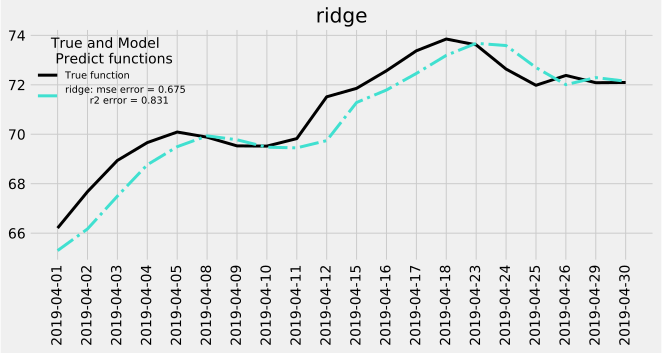

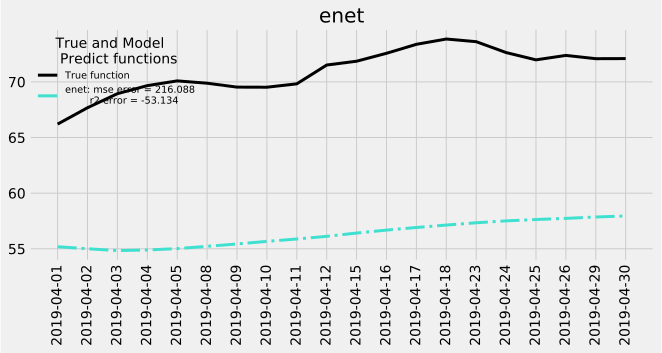

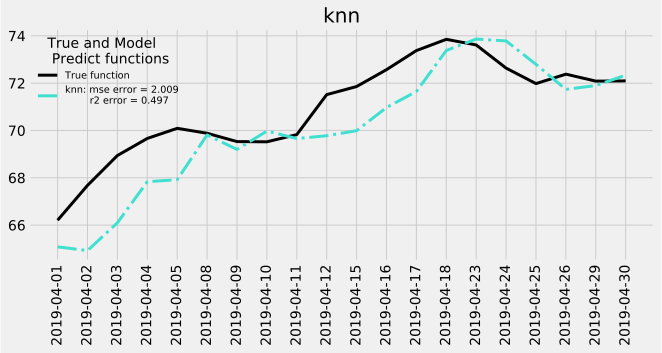

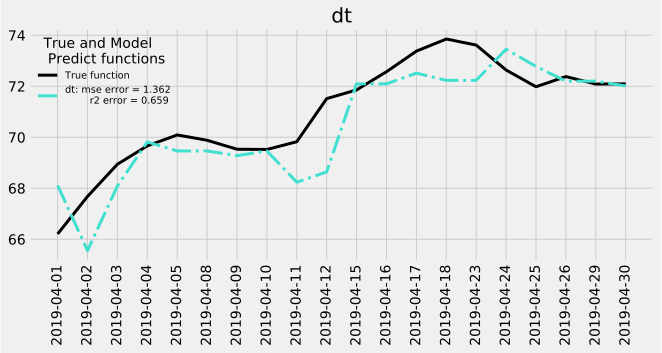

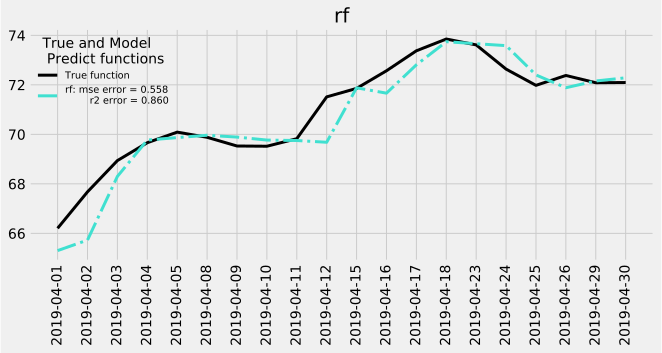

In [16]:
lw = 3

x_plot = new_date
for title, model in model_list:
    plt.figure(figsize=(10, 4))
    plt.xticks(rotation=90)

    plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
    r2 = r2_score(new_y, scaler_y.inverse_transform(model.predict(new_x)))
    mse = mean_squared_error(new_y, scaler_y.inverse_transform(model.predict(new_x)))
    y_plot = scaler_y.inverse_transform(model.predict(new_x))
    plt.plot(x_plot, y_plot, color='turquoise', linestyle='-.',
                 linewidth=lw, label='%s: mse error = %.3f\n        r2 error = %.3f' % (title, mse, r2))

    legend_title = 'True and Model\n Predict functions'
    legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.title(title)
plt.show()

Из полученных результатов видно, что точнее всего модели LinearRegression и RandomForestRegressor.
Попробуем произвести дополнительную настройку RandomForestRegressor. Воспользумся оптимизацией
гиперпараметров модели для того чтобы улучшить качество предсказаний, выдаваемых RF-моделью. Гиперпараметры
можно рассматривать как что-то вроде «настроек» модели. Настройки, которые отлично подходят для одного набора
данных, для другого не подойдут — поэтому и нужно заниматься их оптимизацией.

Применим алгоритм RandomizedSearchCV, который позволяет исследовать широкие диапазоны значений.
В ходе работы мы генерируем словарь random_grid, содержащий для каждого гиперпараметра диапазон значений,
которые нужно испытать. Далее, мы инициализируем объект random_search с помощью функции RandomizedSearchCV(), 
передавая ей RF-модель, param_dist, число итераций и число кросс-валидаций, которые нужно выполнить.

Гиперпараметр verbose позволяет управлять объёмом информации, который выводится моделью в ходе её работы
(наподобие вывода сведений в процессе обучения модели). Гиперпараметр n_jobs позволяет указывать то, сколько
процессорных ядер нужно использовать для обеспечения работы модели. Установка n_jobs в значение -1 приведёт
к более быстрой работе модели, так как при этом будут использоваться все ядра процессора.

Мы будем заниматься подбором следующих гиперпараметров:

n_estimators — число «деревьев» в «случайном лесу». 
max_features — число признаков для выбора расщепления. 
max_depth — максимальная глубина деревьев. 
min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться. 
min_samples_leaf — минимальное число объектов в листьях.

In [17]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 33.1min finished


0.9986981113212343
{'n_estimators': 280, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 8}


Оценим точность модели RF по среднеквадратической ошибке (mean squared error, MSE) и R2 — коэффициенту детерминации.

In [18]:
rf_y_pred_train = random_search.best_estimator_.predict(X_train)
rf_y_pred_valid = random_search.best_estimator_.predict(X_valid)

rf_r2_score_train = r2_score(y_train, rf_y_pred_train)
rf_r2_score_valid = r2_score(y_valid, rf_y_pred_valid)

rf_mse_score_train = mean_squared_error(y_train, rf_y_pred_train)
rf_mse_score_valid = mean_squared_error(y_valid, rf_y_pred_valid)

print('rf:')
print('\tr2 train: {a}\n\tr2 valid: {b}'.format(a=np.round(rf_r2_score_train, 4), b=np.round(rf_r2_score_valid, 4)))
print('\tmse train: {a}\n\tmse valid: {b}'.format(a=np.round(rf_mse_score_train, 4), b=np.round(rf_mse_score_valid, 4)))

rf:
	r2 train: 0.9994
	r2 valid: 0.9987
	mse train: 0.0006
	mse valid: 0.0012


Проверим оптимизированную модель RF при помощи кросс-валидации и вычислим среднее значение и стандартное
отклонение для  R2.

In [19]:
rf_model = RandomForestRegressor(
    n_estimators=280,
    max_depth=8,
    max_features=0.8,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=10, n_jobs=-1)

print('cv mean: {a}'.format(a=np.round(np.mean(scores), 4)))
print('cv std:  {a}'.format(a=np.round(np.std(scores), 4)))

cv mean: 0.9986
cv std:  0.0002


In [20]:
rf_new_y = scaler_y.inverse_transform(rf_model.predict(new_x))

Загрузим из файлов полученные ранее данные нейронных сетей MLP и LSTM.

In [21]:
MLP_new_y = np.load('MLP_new_y.npy')
MLP_y_pred = np.load('MLP_y_pred.npy')
MLP_y = np.load('MLP_y.npy')
MLP_new_y_all = np.load('MLP_new_y_all.npy')
MLP_y_pred_all = np.load('MLP_y_pred_all.npy')
MLP_new_y_1 = np.load('MLP_new_y_1.npy')
MLP_y_pred_1 = np.load('MLP_y_pred_1.npy')
MLP_new_y_2 = np.load('MLP_new_y_2.npy')
MLP_y_pred_2 = np.load('MLP_y_pred_2.npy')
MLP_new_y_3 = np.load('MLP_new_y_3.npy')
MLP_y_pred_3 = np.load('MLP_y_pred_3.npy')
MLP_new_y_4 = np.load('MLP_new_y_4.npy')
MLP_y_pred_4 = np.load('MLP_y_pred_4.npy')
MLP_new_y_5 = np.load('MLP_new_y_5.npy')
MLP_y_pred_5 = np.load('MLP_y_pred_5.npy')
MLP_new_y_6 = np.load('MLP_new_y_6.npy')
MLP_y_pred_6 = np.load('MLP_y_pred_6.npy')
MLP_new_y_pca = np.load('MLP_new_y_pca.npy')
MLP_y_pred_pca = np.load('MLP_y_pred_pca.npy')
MLP_new_y_all_pca = np.load('MLP_new_y_all_pca.npy')
MLP_y_pred_all_pca = np.load('MLP_y_pred_all_pca.npy')

In [22]:
LSTM_new_y = np.load('LSTM_new_y.npy')
LSTM_y_pred = np.load('LSTM_y_pred.npy')
LSTM_y = np.load('LSTM_y.npy')
LSTM_new_y_all = np.load('LSTM_new_y_all.npy')
LSTM_y_pred_all = np.load('LSTM_y_pred_all.npy')
LSTM_new_y_1 = np.load('LSTM_new_y_1.npy')
LSTM_y_pred_1 = np.load('LSTM_y_pred_1.npy')
LSTM_new_y_2 = np.load('LSTM_new_y_2.npy')
LSTM_y_pred_2 = np.load('LSTM_y_pred_2.npy')
LSTM_new_y_3 = np.load('LSTM_new_y_3.npy')
LSTM_y_pred_3 = np.load('LSTM_y_pred_3.npy')
LSTM_new_y_4 = np.load('LSTM_new_y_4.npy')
LSTM_y_pred_4 = np.load('LSTM_y_pred_4.npy')
LSTM_new_y_5 = np.load('LSTM_new_y_5.npy')
LSTM_y_pred_5 = np.load('LSTM_y_pred_5.npy')
LSTM_new_y_6 = np.load('LSTM_new_y_6.npy')
LSTM_y_pred_6 = np.load('LSTM_y_pred_6.npy')
LSTM_new_y_pca = np.load('LSTM_new_y_pca.npy')
LSTM_y_pred_pca = np.load('LSTM_y_pred_pca.npy')
LSTM_new_y_all_pca = np.load('LSTM_new_y_all_pca.npy')
LSTM_y_pred_all_pca = np.load('LSTM_y_pred_all_pca.npy')

Для нейронных сетей оценим точность по MSE и R2.

In [23]:
MLP_r2_score_valid = r2_score(MLP_y, MLP_y_pred)
MLP_mse_score_valid = mean_squared_error(MLP_y, MLP_y_pred)
MLP_r2_score_valid_all = r2_score(MLP_y, MLP_y_pred_all)
MLP_mse_score_valid_all = mean_squared_error(MLP_y, MLP_y_pred_all)
MLP_r2_score_valid_1 = r2_score(MLP_y, MLP_y_pred_1)
MLP_mse_score_valid_1 = mean_squared_error(MLP_y, MLP_y_pred_1)
MLP_r2_score_valid_2 = r2_score(MLP_y, MLP_y_pred_2)
MLP_mse_score_valid_2 = mean_squared_error(MLP_y, MLP_y_pred_2)
MLP_r2_score_valid_3 = r2_score(MLP_y, MLP_y_pred_3)
MLP_mse_score_valid_3 = mean_squared_error(MLP_y, MLP_y_pred_3)
MLP_r2_score_valid_4 = r2_score(MLP_y, MLP_y_pred_4)
MLP_mse_score_valid_4 = mean_squared_error(MLP_y, MLP_y_pred_4)
MLP_r2_score_valid_5 = r2_score(MLP_y, MLP_y_pred_5)
MLP_mse_score_valid_5 = mean_squared_error(MLP_y, MLP_y_pred_5)
MLP_r2_score_valid_6 = r2_score(MLP_y, MLP_y_pred_6)
MLP_mse_score_valid_6 = mean_squared_error(MLP_y, MLP_y_pred_6)
MLP_r2_score_valid_pca = r2_score(MLP_y, MLP_y_pred_pca)
MLP_mse_score_valid_pca = mean_squared_error(MLP_y, MLP_y_pred_pca)
MLP_r2_score_valid_all_pca = r2_score(MLP_y, MLP_y_pred_all_pca)
MLP_mse_score_valid_all_pca = mean_squared_error(MLP_y, MLP_y_pred_all_pca)
print('MLP r2: {a}'.format(a=np.round(MLP_r2_score_valid, 4)))
print('MLP mse: {a}'.format(a=np.round(MLP_mse_score_valid, 4)))
print('MLP_all r2: {a}'.format(a=np.round(MLP_r2_score_valid_all, 4)))
print('MLP_all mse: {a}'.format(a=np.round(MLP_mse_score_valid_all, 4)))
print('MLP_1 r2: {a}'.format(a=np.round(MLP_r2_score_valid_1, 4)))
print('MLP_1 mse: {a}'.format(a=np.round(MLP_mse_score_valid_1, 4)))
print('MLP_2 r2: {a}'.format(a=np.round(MLP_r2_score_valid_2, 4)))
print('MLP_2 mse: {a}'.format(a=np.round(MLP_mse_score_valid_2, 4)))
print('MLP_3 r2: {a}'.format(a=np.round(MLP_r2_score_valid_3, 4)))
print('MLP_3 mse: {a}'.format(a=np.round(MLP_mse_score_valid_3, 4)))
print('MLP_4 r2: {a}'.format(a=np.round(MLP_r2_score_valid_4, 4)))
print('MLP_4 mse: {a}'.format(a=np.round(MLP_mse_score_valid_4, 4)))
print('MLP_5 r2: {a}'.format(a=np.round(MLP_r2_score_valid_5, 4)))
print('MLP_5 mse: {a}'.format(a=np.round(MLP_mse_score_valid_5, 4)))
print('MLP_6 r2: {a}'.format(a=np.round(MLP_r2_score_valid_6, 4)))
print('MLP_6 mse: {a}'.format(a=np.round(MLP_mse_score_valid_6, 4)))
print('MLP_pca r2: {a}'.format(a=np.round(MLP_r2_score_valid_pca, 4)))
print('MLP_pca mse: {a}'.format(a=np.round(MLP_mse_score_valid_pca, 4)))
print('MLP_all_pca r2: {a}'.format(a=np.round(MLP_r2_score_valid_all_pca, 4)))
print('MLP_all_pca mse: {a}'.format(a=np.round(MLP_mse_score_valid_all_pca, 4)))

MLP r2: 0.9983
MLP mse: 0.8718
MLP_all r2: 0.6126
MLP_all mse: 203.8934
MLP_1 r2: 0.5903
MLP_1 mse: 215.6285
MLP_2 r2: 0.6526
MLP_2 mse: 182.8417
MLP_3 r2: 0.6526
MLP_3 mse: 182.8738
MLP_4 r2: 0.6093
MLP_4 mse: 205.6274
MLP_5 r2: 0.632
MLP_5 mse: 193.6906
MLP_6 r2: 0.6658
MLP_6 mse: 175.9302
MLP_pca r2: 0.6387
MLP_pca mse: 190.1971
MLP_all_pca r2: 0.6354
MLP_all_pca mse: 191.9135


In [24]:
LSTM_r2_score_valid = r2_score(LSTM_y, LSTM_y_pred)
LSTM_mse_score_valid = mean_squared_error(LSTM_y, LSTM_y_pred)
LSTM_r2_score_valid_all = r2_score(LSTM_y, LSTM_y_pred_all)
LSTM_mse_score_valid_all = mean_squared_error(LSTM_y, LSTM_y_pred_all)
LSTM_r2_score_valid_1 = r2_score(LSTM_y, LSTM_y_pred_1)
LSTM_mse_score_valid_1 = mean_squared_error(LSTM_y, LSTM_y_pred_1)
LSTM_r2_score_valid_2 = r2_score(LSTM_y, LSTM_y_pred_2)
LSTM_mse_score_valid_2 = mean_squared_error(LSTM_y, LSTM_y_pred_2)
LSTM_r2_score_valid_3 = r2_score(LSTM_y, LSTM_y_pred_3)
LSTM_mse_score_valid_3 = mean_squared_error(LSTM_y, LSTM_y_pred_3)
LSTM_r2_score_valid_4 = r2_score(LSTM_y, LSTM_y_pred_4)
LSTM_mse_score_valid_4 = mean_squared_error(LSTM_y, LSTM_y_pred_4)
LSTM_r2_score_valid_5 = r2_score(LSTM_y, LSTM_y_pred_5)
LSTM_mse_score_valid_5 = mean_squared_error(LSTM_y, LSTM_y_pred_5)
LSTM_r2_score_valid_6 = r2_score(LSTM_y, LSTM_y_pred_6)
LSTM_mse_score_valid_6 = mean_squared_error(LSTM_y, LSTM_y_pred_6)
LSTM_r2_score_valid_pca = r2_score(LSTM_y, LSTM_y_pred_pca)
LSTM_mse_score_valid_pca = mean_squared_error(LSTM_y, LSTM_y_pred_pca)
LSTM_r2_score_valid_all_pca = r2_score(LSTM_y, LSTM_y_pred_all_pca)
LSTM_mse_score_valid_all_pca = mean_squared_error(LSTM_y, LSTM_y_pred_all_pca)
print('LSTM r2: {a}'.format(a=np.round(LSTM_r2_score_valid, 4)))
print('LSTM mse: {a}'.format(a=np.round(LSTM_mse_score_valid, 4)))
print('LSTM_all r2: {a}'.format(a=np.round(LSTM_r2_score_valid_all, 4)))
print('LSTM_all mse: {a}'.format(a=np.round(LSTM_mse_score_valid_all, 4)))
print('LSTM_1 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_1, 4)))
print('LSTM_1 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_1, 4)))
print('LSTM_2 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_2, 4)))
print('LSTM_2 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_2, 4)))
print('LSTM_3 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_3, 4)))
print('LSTM_3 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_3, 4)))
print('LSTM_4 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_4, 4)))
print('LSTM_4 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_4, 4)))
print('LSTM_5 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_5, 4)))
print('LSTM_5 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_5, 4)))
print('LSTM_6 r2: {a}'.format(a=np.round(LSTM_r2_score_valid_6, 4)))
print('LSTM_6 mse: {a}'.format(a=np.round(LSTM_mse_score_valid_6, 4)))
print('LSTM_pca r2: {a}'.format(a=np.round(LSTM_r2_score_valid_pca, 4)))
print('LSTM_pca mse: {a}'.format(a=np.round(LSTM_mse_score_valid_pca, 4)))
print('LSTM_all_pca r2: {a}'.format(a=np.round(LSTM_r2_score_valid_all_pca, 4)))
print('LSTM_all_pca mse: {a}'.format(a=np.round(LSTM_mse_score_valid_all_pca, 4)))

LSTM r2: 0.9977
LSTM mse: 1.1998
LSTM_all r2: 0.5976
LSTM_all mse: 211.7954
LSTM_1 r2: -1.0116
LSTM_1 mse: 1058.8427
LSTM_2 r2: 0.6051
LSTM_2 mse: 207.8867
LSTM_3 r2: 0.6437
LSTM_3 mse: 187.531
LSTM_4 r2: 0.6613
LSTM_4 mse: 178.3038
LSTM_5 r2: 0.6418
LSTM_5 mse: 188.5687
LSTM_6 r2: -1.0116
LSTM_6 mse: 1058.8427
LSTM_pca r2: 0.6227
LSTM_pca mse: 198.6011
LSTM_all_pca r2: 0.613
LSTM_all_pca mse: 203.717


Построим график с контрольными предсказаниями для LinearRegression, RandomForestRegressor, MLP и LSTM.

In [25]:
MLP_new_y.reshape(20,)

array([64.335304, 65.46374 , 66.74292 , 68.11506 , 68.783775, 69.20789 ,
       68.98559 , 68.65544 , 68.60522 , 68.90241 , 70.46018 , 71.003365,
       71.5923  , 72.37473 , 72.80088 , 72.74682 , 71.787926, 71.04231 ,
       71.32182 , 71.21891 ], dtype=float32)

In [26]:
LSTM_new_y.reshape(20,)

array([65.07499 , 65.743355, 66.88334 , 68.23565 , 69.45699 , 70.3571  ,
       70.73444 , 70.65673 , 70.44857 , 70.372246, 71.020744, 71.763016,
       72.55727 , 73.39154 , 74.103355, 74.39881 , 74.045906, 73.35933 ,
       72.9804  , 72.694595], dtype=float32)

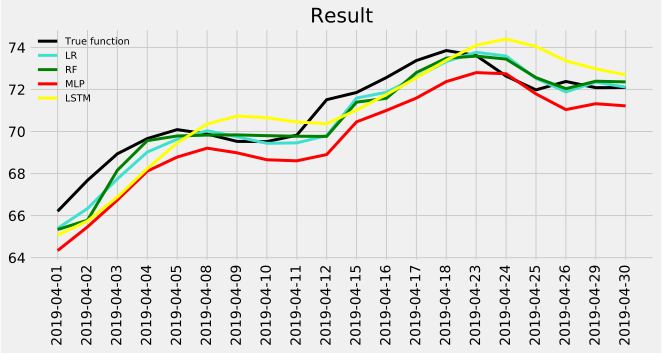

In [27]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = scaler_y.inverse_transform(model_list[0][1].predict(new_x))
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='LR')

y2_plot = rf_new_y
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='RF')

y3_plot = MLP_new_y
plt.plot(x_plot, y3_plot, color='red', linestyle='-',
                 linewidth=lw, label='MLP')

y4_plot = LSTM_new_y
plt.plot(x_plot, y4_plot, color='yellow', linestyle='-',
                 linewidth=lw, label='LSTM')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('Result')
plt.show()

In [28]:
MLP_new_y_all.reshape(20,)
MLP_new_y_1.reshape(20,)
MLP_new_y_2.reshape(20,)
MLP_new_y_3.reshape(20,)
MLP_new_y_4.reshape(20,)
MLP_new_y_5.reshape(20,)
MLP_new_y_6.reshape(20,)
MLP_new_y_pca.reshape(20,)
MLP_new_y_all_pca.reshape(20,)

array([68.72444 , 70.08056 , 71.22124 , 72.75204 , 73.477516, 73.96004 ,
       73.254265, 73.19861 , 72.98034 , 73.070724, 74.66429 , 75.14563 ,
       75.99513 , 77.018524, 77.3771  , 77.42703 , 76.26694 , 75.43346 ,
       75.78012 , 75.849144], dtype=float32)

In [29]:
LSTM_new_y_all.reshape(20,)
LSTM_new_y_1.reshape(20,)
LSTM_new_y_2.reshape(20,)
LSTM_new_y_3.reshape(20,)
LSTM_new_y_4.reshape(20,)
LSTM_new_y_5.reshape(20,)
LSTM_new_y_6.reshape(20,)
LSTM_new_y_pca.reshape(20,)
LSTM_new_y_all_pca.reshape(20,)

array([69.492226, 70.92882 , 71.98973 , 73.64333 , 74.087   , 74.641846,
       73.707664, 73.68061 , 73.463844, 73.71815 , 74.75954 , 76.004364,
       76.92148 , 77.9387  , 78.276344, 78.25242 , 76.83406 , 76.270874,
       76.361275, 76.46833 ], dtype=float32)

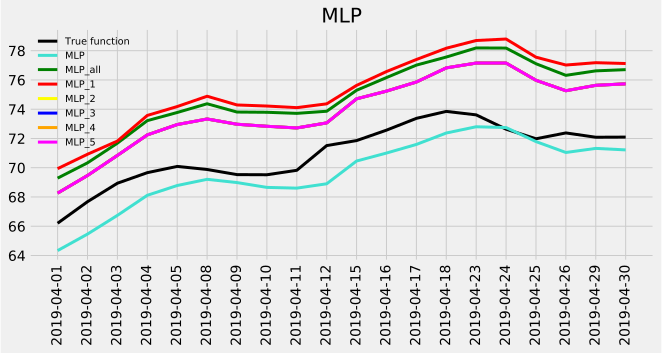

In [30]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = MLP_new_y
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='MLP')

y2_plot = MLP_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='MLP_all')

y3_plot = MLP_new_y_1
plt.plot(x_plot, y3_plot, color='red', linestyle='-',
                 linewidth=lw, label='MLP_1')

y4_plot = MLP_new_y_2
plt.plot(x_plot, y4_plot, color='yellow', linestyle='-',
                 linewidth=lw, label='MLP_2')

y5_plot = MLP_new_y_3
plt.plot(x_plot, y4_plot, color='blue', linestyle='-',
                 linewidth=lw, label='MLP_3')

y6_plot = MLP_new_y_4
plt.plot(x_plot, y4_plot, color='orange', linestyle='-',
                 linewidth=lw, label='MLP_4')

y7_plot = MLP_new_y_5
plt.plot(x_plot, y4_plot, color='magenta', linestyle='-',
                 linewidth=lw, label='MLP_5')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('MLP')
plt.show()

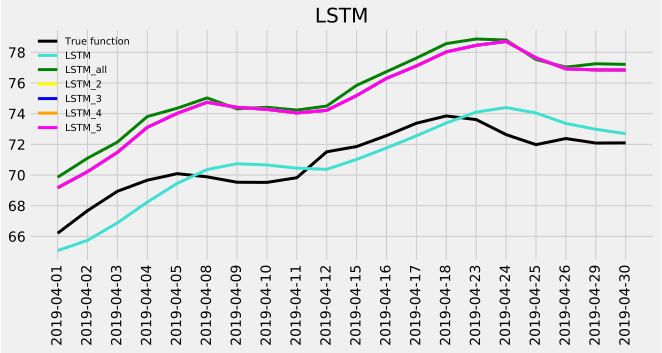

In [31]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = LSTM_new_y
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='LSTM')

y2_plot = LSTM_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='LSTM_all')

#y3_plot = LSTM_new_y_1
#plt.plot(x_plot, y3_plot, color='red', linestyle='-',
#                 linewidth=lw, label='LSTM_1')

y4_plot = LSTM_new_y_2
plt.plot(x_plot, y4_plot, color='yellow', linestyle='-',
                 linewidth=lw, label='LSTM_2')

y5_plot = LSTM_new_y_3
plt.plot(x_plot, y4_plot, color='blue', linestyle='-',
                 linewidth=lw, label='LSTM_3')

y6_plot = LSTM_new_y_4
plt.plot(x_plot, y4_plot, color='orange', linestyle='-',
                 linewidth=lw, label='LSTM_4')

y7_plot = LSTM_new_y_5
plt.plot(x_plot, y4_plot, color='magenta', linestyle='-',
                 linewidth=lw, label='LSTM_5')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('LSTM')
plt.show()

In [32]:
X_train_all_lr = np.array([x.flatten() for x in X_train_all])
X_valid_all_lr = np.array([x.flatten() for x in X_valid_all])
new_x_all_lr = np.array([x.flatten() for x in new_x_all])
X_train_all_pca_lr = np.array([x.flatten() for x in X_train_all_pca])
X_valid_all_pca_lr = np.array([x.flatten() for x in X_valid_all_pca])
new_x_all_pca_lr = np.array([x.flatten() for x in new_x_all_pca])
new_x_all_lr.shape
lr_model_all = LinearRegression()
lr_model_all.fit(X_train_all_lr, y_train_all)
lr_new_y_all = scaler_y.inverse_transform(lr_model_all.predict(new_x_all_lr))
lr_model_all_pca = LinearRegression()
lr_model_all_pca.fit(X_train_all_pca_lr, y_train_all_pca)
lr_new_y_all_pca = scaler_y.inverse_transform(lr_model_all_pca.predict(new_x_all_pca_lr))

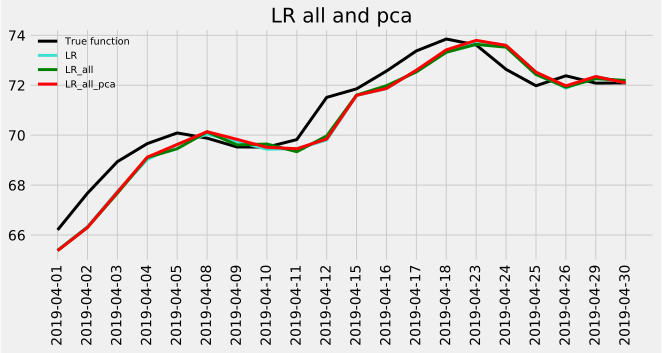

In [33]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = scaler_y.inverse_transform(model_list[0][1].predict(new_x))
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='LR')

y2_plot = lr_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='LR_all')

y3_plot = lr_new_y_all_pca
plt.plot(x_plot, y3_plot, color='red', linestyle='-',
                 linewidth=lw, label='LR_all_pca')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('LR all and pca')
plt.show()

In [34]:
rg_model_all = Ridge(random_state=42)
rg_model_all.fit(X_train_all_lr, y_train_all)
rg_new_y_all = scaler_y.inverse_transform(rg_model_all.predict(new_x_all_lr))
rg_model_all_pca = Ridge(random_state=42)
rg_model_all_pca.fit(X_train_all_pca_lr, y_train_all_pca)
rg_new_y_all_pca = scaler_y.inverse_transform(rg_model_all_pca.predict(new_x_all_pca_lr))

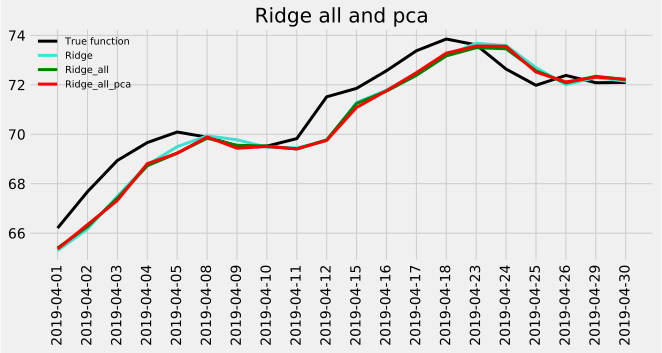

In [35]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = scaler_y.inverse_transform(model_list[2][1].predict(new_x))
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='Ridge')

y2_plot = rg_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='Ridge_all')

y3_plot = rg_new_y_all_pca
plt.plot(x_plot, y3_plot, color='red', linestyle='-',
                 linewidth=lw, label='Ridge_all_pca')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('Ridge all and pca')
plt.show()

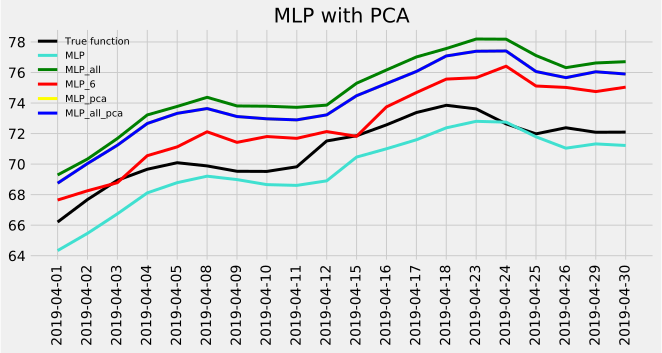

In [36]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = MLP_new_y
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='MLP')

y2_plot = MLP_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='MLP_all')

y3_plot = MLP_new_y_6
plt.plot(x_plot, y3_plot, color='red', linestyle='-',
                 linewidth=lw, label='MLP_6')

y4_plot = MLP_new_y_pca
plt.plot(x_plot, y4_plot, color='yellow', linestyle='-',
                 linewidth=lw, label='MLP_pca')

y5_plot = MLP_new_y_all_pca
plt.plot(x_plot, y4_plot, color='blue', linestyle='-',
                 linewidth=lw, label='MLP_all_pca')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('MLP with PCA')
plt.show()

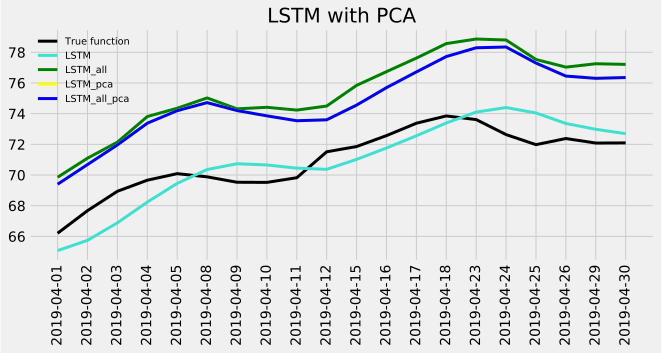

In [37]:
lw = 3

x_plot = new_date
plt.figure(figsize=(10, 4))
plt.xticks(rotation=90)

plt.plot(x_plot, new_y, color='black', linestyle='-',
                 linewidth=lw, label='True function')
    
y1_plot = LSTM_new_y
plt.plot(x_plot, y1_plot, color='turquoise', linestyle='-',
                 linewidth=lw, label='LSTM')

y2_plot = LSTM_new_y_all
plt.plot(x_plot, y2_plot, color='green', linestyle='-',
                 linewidth=lw, label='LSTM_all')

#y3_plot = LSTM_new_y_6
#plt.plot(x_plot, y3_plot, color='red', linestyle='-',
#                 linewidth=lw, label='LSTM_6')

y4_plot = LSTM_new_y_pca
plt.plot(x_plot, y4_plot, color='yellow', linestyle='-',
                 linewidth=lw, label='LSTM_pca')

y5_plot = LSTM_new_y_all_pca
plt.plot(x_plot, y4_plot, color='blue', linestyle='-',
                 linewidth=lw, label='LSTM_all_pca')

legend_title = ''
legend = plt.legend(loc='upper left', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
plt.title('LSTM with PCA')
plt.show()